In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib as plt

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor

In [3]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [4]:
##Update this, its probably not where your DB is
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v4.db')


Get the on scene time and response time from calls for service, join it to the catchment output to get zone_idx, accessibiliy, also getting primary situation index

In [5]:
    cur = con.cursor()

    df = pd.read_sql("select calls_for_service.call_number " \
        ", calls_for_service.incident_number " \
        ", floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        ", category_mappings.[index] as primary_situation_index " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "left join fire_incidents AS fi on calls_for_service.incident_number = fi.incident_number " \
        "left join category_mappings on fi.primary_situation = category_mappings.primary_situation " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con) 

In [6]:
df.head()

,index,zone_idx,accessibility_score,scenario_name,on_scene_dttm,response_dttm,primary_situation_index
0,0,8,0.000803,baseline,2019-01-01 16:25:28,01/01/2019 04:22:21 PM,NaN
1,0,8,0.000803,baseline,2019-01-01 16:23:04,01/01/2019 04:18:06 PM,NaN
2,0,8,0.000803,baseline,2019-01-02 15:35:57,01/02/2019 03:31:21 PM,NaN
3,0,8,0.000803,baseline,2019-01-05 20:41:37,01/05/2019 08:40:16 PM,NaN
4,0,8,0.000803,baseline,2019-01-06 00:54:34,01/06/2019 12:52:49 AM,148.0


In [7]:
#do some date math
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds) 

In [8]:
#rool up accessibility and minutes to zone
df_ag = df.groupby(["zone_idx"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
df_ag.head()

,zone_idx,accessibility_score,minutes
0,8,0.000803,5.254762
1,9,0.001147,4.466082
2,10,0.000968,4.545000
3,11,0.000501,3.450722
4,12,0.000501,4.271189


In [10]:
# hide the warings.
# I mean if it was really important it would just be an error, so blissfully ignore
warnings.filterwarnings('ignore')

# set the training variables
df_ag.target_to_predict = 'minutes'
df_ag.predictors = ['zone_idx', 'accessibility_score']

df_ag.x = df_ag[df_ag.predictors].values
df_ag.y = df_ag[df_ag.target_to_predict].values

df_ag.x_train, df_ag.x_test, df_ag.y_train, df_ag.y_test = train_test_split(df_ag.x, df_ag.y, test_size=0.8, random_state=42)



In [11]:
#copy/paste code:

def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=4000, subsample=0.9, colsample_bynode=0.2)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('md.ytest', md.y_test)
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')



XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.904142039837595
md.ytest [ 5.94589744  2.84603321  3.44164288  3.87233857  3.36646259  6.16362683
  3.2568662   2.92944051  3.42081413  3.31143568  4.18966245  3.04530864
  4.42083333  4.68795761  3.0220802   3.82216828  3.6347079   4.86888889
  4.08554293  2.22961203  3.22892416  3.44002123  6.4191

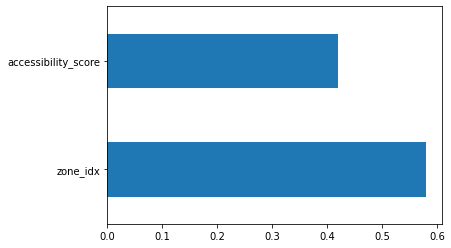

In [12]:
create_model(df_ag)

In [40]:
#Get data to predict
cur = con.cursor()
scenario_name = "baseline"
df_to_predict = pd.read_sql(('select zone_idx, accessibility_score from floating_catchment_output where scenario_name = ?'), con=con,params=[scenario_name])
df_to_predict.head()
df_to_predict.count()

zone_idx               260
accessibility_score    260
dtype: int64

In [41]:
#do prediction and append predicted values
prediction = df_ag.XGB.predict(df_to_predict)
print(len(prediction))
df_to_predict['predicted_minutes'] = prediction





260


In [43]:

print(df_to_predict[df_to_predict["zone_idx"]==8])
print(df_ag[df_ag["zone_idx"]==8])

   zone_idx  accessibility_score  predicted_minutes
0         8             0.000803           4.184931
   zone_idx  accessibility_score   minutes
0         8             0.000803  5.254762
